In [1]:
import copy
from pathlib import Path
import warnings
import os

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
import tensorboard as tb

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE, QuantileLoss, MultivariateNormalDistributionLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data import TorchNormalizer

from dataloader import TimeSeriesLoader

In [2]:
# suppose the raw dataset is downloaded and unzipped under Open-source-power-dataset
# data loaders are iterable
loader = TimeSeriesLoader(task='forecasting', root='../PSML')
train_loader, test_loader = loader.load(batch_size=32, shuffle=True)

0/66


In [66]:
device = 'cuda'

# Process

1. Shape dataset (from csvs) per instrucitons in `pytorch-forecasting` docs into a `TimeSeriesDataset`
2. Batch via DataLoader per tutorial

In [2]:
data_original = pd.read_csv('../PSML/Minute-level Load and Renewable/CAISO_zone_1_.csv')

In [3]:
data_original.shape

(1573923, 12)

In [87]:
root = '../PSML'
data_folder = os.path.join(root, 'processed_dataset', 'forecasting')
location = 'CAISO_zone_1'
years = ['2018', '2019', '2020']

data = pd.DataFrame()
data_dfs = []

for year in years:
    data_append = pd.read_csv(os.path.join(data_folder, f'{location}_{year}.csv'))
    
    # turn holiday into categorical
    data_append['holiday'] = pd.Categorical(data_append['holiday'].astype(str))
    data_append['weekday'] = pd.Categorical(data_append['weekday'].astype(str))
    data_append['constant'] = 'filler'
    
    data_dfs.append(data_append)
    data = pd.concat((data, data_append), ignore_index=True)

data_2018 = data_dfs[0]
data_2019 = data_dfs[1]
data_2020 = data_dfs[2]
data['ID'] = data.index
data

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag,constant
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.880,1.2,...,1.0,0.005297,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.842,1.2,...,1.0,0.005203,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.804,1.2,...,1.0,0.005109,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.766,1.2,...,1.0,0.005015,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.728,1.2,...,1.0,0.004921,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573918,1573918,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,169.010,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler
1573919,1573919,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.990,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler
1573920,1573920,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.970,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler
1573921,1573921,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.950,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573923 entries, 0 to 1573922
Data columns (total 29 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   ID                  1573923 non-null  int64   
 1   month_day           1573923 non-null  float64 
 2   weekday             1573923 non-null  category
 3   holiday             1573923 non-null  category
 4   DHI                 1573923 non-null  float64 
 5   DNI                 1573923 non-null  float64 
 6   GHI                 1573923 non-null  float64 
 7   Dew Point           1573923 non-null  float64 
 8   Solar Zenith Angle  1573923 non-null  float64 
 9   Wind Speed          1573923 non-null  float64 
 10  Relative Humidity   1573923 non-null  float64 
 11  Temperature         1573923 non-null  float64 
 12  yl_t                1573923 non-null  float64 
 13  yl_t+60(val)        1573923 non-null  float64 
 14  yl_t+60(flag)       1573923 non-null  float64 
 15

Pick one of the tasks and train a model based on it. We'll use hourly load prediction.

In [89]:
data['holiday']

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
1573918    0.0
1573919    0.0
1573920    0.0
1573921    0.0
1573922    0.0
Name: holiday, Length: 1573923, dtype: category
Categories (2, object): ['0.0', '1.0']

In [133]:
time_col = 'ID'
target_y_flag = 'yl_t+60(flag)'
target_y = 'yl_t+60(val)'
data_yl_t60 = data_2018[data_2018[target_y_flag] == 1].reset_index(drop=True)
# data_yl_t60 = data_2018.reset_index(drop=True)
data_yl_t60['ID'] = data_yl_t60.index
data_yl_t60

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag,constant
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.88,1.2,...,1.0,0.005297,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-8.4,161.76,1.2,...,1.0,0.005360,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-9.2,150.28,1.3,...,1.0,0.005413,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-9.9,137.98,1.4,...,1.0,0.006356,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-10.4,125.56,1.5,...,1.0,0.007392,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,8730,12.967742,6.0,0.0,0.0,0.0,0.0,6.5,116.08,1.1,...,1.0,0.005245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler
8731,8731,12.967742,6.0,0.0,0.0,0.0,0.0,7.0,128.39,1.0,...,1.0,0.003749,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler
8732,8732,12.967742,6.0,0.0,0.0,0.0,0.0,7.3,140.80,1.4,...,1.0,0.008951,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler
8733,8733,12.967742,6.0,0.0,0.0,0.0,0.0,7.1,153.02,1.6,...,1.0,0.010854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler


In [136]:
dataset_df = data_yl_t60
train_cutoff_idx = dataset_df[dataset_df['month_day'] >= 10][time_col].values[0]
val_cutoff_idx = dataset_df[dataset_df['month_day'] >= 12][time_col].values[0]

In [138]:
dataset_df.groupby(target_y).count().sort_values('ID', ascending=False)

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag,constant
yl_t+60(val),,,,,,,,,,,,,,,,,,,,,
0.788434,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.752175,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.737033,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.850957,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.932787,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.908638,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.908400,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.908310,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [139]:
dataset_df.iloc[:, :14]

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,Relative Humidity,Temperature,yl_t,yl_t+60(val)
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.88,1.2,23.78,12.5,0.785327,0.751928
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-8.4,161.76,1.2,22.59,12.4,0.751928,0.726002
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-9.2,150.28,1.3,21.91,11.9,0.726002,0.712764
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-9.9,137.98,1.4,22.24,10.9,0.712764,0.710416
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-10.4,125.56,1.5,22.26,10.3,0.710416,0.729610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,8730,12.967742,6.0,0.0,0.0,0.0,0.0,6.5,116.08,1.1,98.14,6.8,0.979627,0.962109
8731,8731,12.967742,6.0,0.0,0.0,0.0,0.0,7.0,128.39,1.0,100.00,7.0,0.962109,0.926617
8732,8732,12.967742,6.0,0.0,0.0,0.0,0.0,7.3,140.80,1.4,93.98,8.2,0.926617,0.878301
8733,8733,12.967742,6.0,0.0,0.0,0.0,0.0,7.1,153.02,1.6,91.09,8.5,0.878301,0.820347


In [153]:
max_prediction_length = 24
max_encoder_length = 48
training_cutoff = train_cutoff_idx - max_prediction_length

training = TimeSeriesDataSet(
    dataset_df[lambda x: x[time_col] <= training_cutoff],
    time_idx=time_col,
    target=target_y,
    group_ids=['constant'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=['holiday', 'weekday'],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['month_day'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'DHI',
        'DNI',
        'GHI',
        'Dew Point',
        'Solar Zenith Angle',
        'Wind Speed',
        'Relative Humidity',
        'Temperature',
        target_y,
    ],
#     target_normalizer=TorchNormalizer(
#         method='identity', center=True, transformation=None, method_kwargs={}
#     ), # https://github.com/jdb78/pytorch-forecasting/issues/1220
#     add_relative_time_idx=True,
    add_target_scales=True,
#     add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training,
    dataset_df,
    predict=True,
    stop_randomization=True,
    min_prediction_idx=train_cutoff_idx + 1,
)
testing = TimeSeriesDataSet.from_dataset(
    training,
    dataset_df,
    predict=True,
    stop_randomization=True,
    min_prediction_idx=val_cutoff_idx - 1,
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, pin_memory=True, batch_sampler='synchronized')
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, pin_memory=True, batch_sampler='synchronized')
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, pin_memory=True, batch_sampler='synchronized')

In [154]:
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(device)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)]).to(device)

In [155]:
val_actuals.get_device()

0

In [156]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"))

rmse = RMSE().to(device)
print(rmse(baseline_predictions, val_actuals))

mae = MAE().to(device)
print(mae(baseline_predictions, val_actuals))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.0795, device='cuda:0')
tensor(0.0654, device='cuda:0')


### Find optimal learning rate

1st Optuna study results:

```{'gradient_clip_val': 0.04684428696051076, 'hidden_size': 56, 'dropout': 0.1527054902258637, 'hidden_continuous_size': 13, 'attention_head_size': 2, 'learning_rate': 0.0052480746024977255}```

In [157]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42


Number of parameters in network: 23.6k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 1.8197008586099834e-05


suggested learning rate: 1.8197008586099834e-05


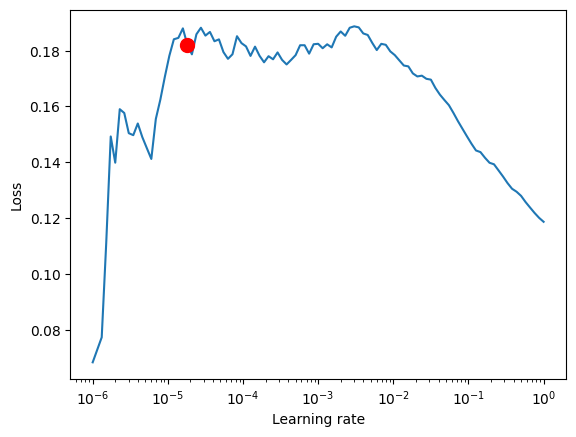

In [158]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

# minor precision sacrifice for major performance gains on CUDA-enabled GPU
torch.set_float32_matmul_precision('high')

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [159]:
optimal_lr = 0.00002

In [160]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=25,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    limit_val_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    enable_checkpointing=True,
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=optimal_lr,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 23.6k


In [161]:
# fit network

# minor precision sacrifice for major performance gains on CUDA-enabled GPU
torch.set_float32_matmul_precision('high')

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 37    
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 768   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [162]:
# calculate mean absolute error on validation set
val_predictions = tft.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"))
print('RMSE:', rmse(val_predictions, val_actuals))
print('MAE:', mae(val_predictions, val_actuals))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: tensor(0.1215, device='cuda:0')
MAE: tensor(0.1128, device='cuda:0')


### Hyperparameter tuning

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=25,
    timeout=10000,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 164),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=50, limit_val_batches=50),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-04-30 16:28:39,485] A new study created in memory with name: no-name-3103b451-5852-4287-a709-3e1405d40138
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.006606934480075959
[I 2023-04-30 16:28:42,427] Using learning rate of 0.0457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:29:18,041] Trial 0 finished with value: 0.06610722094774246 and parameters: {'gradient_clip_val': 0.9263499090725235, 'hidden_size': 14, 'dropout': 0.23140809217227237, 'hidden_continuous_size': 12, 'attention_head_size': 4, 'learning_rate': 0.0457088189614875}. Best is trial 0 with value: 0.06610722094774246.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:29:20,760] Using learning rate of 0.00251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:29:56,299] Trial 1 finished with value: 0.05338713526725769 and parameters: {'gradient_clip_val': 0.9613991724358169, 'hidden_size': 15, 'dropout': 0.27807987453815886, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0025118864315095803}. Best is trial 1 with value: 0.05338713526725769.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0023988329190194903
[I 2023-04-30 16:29:58,809] Using learning rate of 0.00263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [23]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
RMSE()(predictions.output, predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1280 but got size 962 for tensor number 381 in the list.

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="gpu"),
)

In [ ]:
# Plotting
series = validation.x_to_index(raw_predictions.x)["series"]
#for idx in range(10):  # plot 10 examples
#    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
#    plt.suptitle(f"Series: {series.iloc[idx]}")
#    plt.show()
best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
plt.show()
# plt.close()

In [ ]:
# Test set
predictions_test = best_model.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"))
RMSE()(predictions_test.output, predictions_test.y)